In [42]:
%matplotlib inline

import functools
import os
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook
tqdm.pandas("Progress: ")

import numpy as np
import matplotlib
import pandas as pd
import pybedtools
import pysam
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import scipy
from gscripts import qtools
from Bio import SeqIO
from gscripts.general import dataviz
from IPython.core.display import HTML

img_dir = "/home/gpratt/Dropbox/EricGabe_ENCODE/papers/peaks_outside_genes"

sns.set_style("ticks")


In [53]:
import matplotlib as mpl
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [7]:
input_norm_dir = "/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20170130"
split_dir = "/home/gpratt/projects/idr/analysis/idr_v1/"
out_dir = "/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/"
downsample_path = "/home/gpratt/projects/idr/analysis/downsample_v2/"

In [8]:
def get_gps_peak(fn):
    gps_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    fn = os.path.basename(fn)
    basename = fn.split(".")[0]
    
    fn = os.path.join(gps_dir, "{}/{}_outputs/{}_2_GEM_events.bed".format(basename, basename, basename))
    return fn

def make_and_filter_clipper(fn, l2fc, pval):
    bedtool = pybedtools.BedTool(fn)
    
    filter_data_inst = functools.partial(filter_data, l2fc=l2fc, pval=pval)
    out_file = os.path.join(out_dir, os.path.basename(bedtool.fn) + "l2fc_{}_pval_{}.clipper.bed".format(l2fc, pval))
    if not os.path.exists(out_file):
        bedtool = bedtool.filter(filter_data_inst).saveas(out_file)

    return out_file

def make_clipper_ish(interval):
    interval.name = interval[7]
    interval[6] = interval.start
    interval[7] = interval.stop
    return interval

def filter_data(interval, l2fc, pval):
    #col4 is -log10 p-val
    #col5 is -log2 fold enrichment

    #This is the standard one 
    return (float(interval[3]) >= pval) and (float(interval[4]) >= l2fc)

def format_frip_analysis(bam_file, bed_file, out_file=None):
    path, ext = os.path.splitext(os.path.basename(bed_file))
    if not out_file:
        metrics = path + ".metrics"
    else:
        metrics = out_file
        
    return "python /home/gpratt/gscripts/gscripts/clipseq/calculate_frip.py --bed {} --bam {} --out_file {}".format(bed_file, bam_file, metrics)

def sort_and_return_peaks(fn, force=False):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    out_fn = os.path.join(out_dir, os.path.basename(fn))
    if os.path.exists(out_fn) and not force:
        return out_fn
    
    bedtool = pybedtools.BedTool(fn)
    bedtool = pybedtools.BedTool([pybedtools.create_interval_from_list(str(interval).split()) for interval in bedtool])

    
    bedtool = bedtool.sort().saveas(out_fn)
    return bedtool.fn

In [9]:
make_and_filter_clipper_stringent = functools.partial(make_and_filter_clipper, l2fc=5, pval=3)
make_and_filter_clipper_very_lineant = functools.partial(make_and_filter_clipper, l2fc=0, pval=1)
make_and_filter_clipper_lineant = functools.partial(make_and_filter_clipper, l2fc=2, pval=1.3)
make_and_filter_clipper_moderate = functools.partial(make_and_filter_clipper, l2fc=3, pval=3)

In [10]:
#Converts reps into dataframe, like they should be
submitted_datasets = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20170130/ALLDATASETS_submittedonly.txt")
submitted_datasets = submitted_datasets.set_index(["uID", "RBP", "Cell line", "INPUT"])
submitted_datasets.columns = pd.MultiIndex.from_tuples([item.split("_") for item in submitted_datasets.columns])
submitted_datasets = submitted_datasets.stack()
submitted_datasets['INPUT'] = submitted_datasets.index.get_level_values(level="INPUT")
submitted_datasets.index = submitted_datasets.index.droplevel("INPUT")

In [11]:
def format_input_norm(row):
    uID = row.name[0]
    rep = row.name[-1]
    if rep == "rep1":
        rep_num = "01"
    elif rep == "rep2":
        rep_num = "02"
    else:
        print "error"
    #The one shitty part of this new approach is being careful how I deal with the input norm datasets
    return os.path.join(input_norm_dir, "{0}_{1}.basedon_{0}_{1}.peaks.l2inputnormnew.bed.compressed.bed.annotated".format(uID, rep_num))

In [12]:
#Format Data
submitted_datasets['gps'] = submitted_datasets.CLIP.apply(get_gps_peak)
submitted_datasets['input_norm'] = submitted_datasets.apply(format_input_norm, axis=1)
submitted_datasets = submitted_datasets[submitted_datasets['input_norm'].apply(os.path.exists)]
submitted_datasets['filtered_moderate'] = submitted_datasets['input_norm'].progress_apply(make_and_filter_clipper_moderate)


100%|██████████| 362/362 [00:00<00:00, 759.36it/s]


In [13]:
#How many peak files don't exist
existing_peaks = submitted_datasets["gps"].apply(os.path.exists)
print len(submitted_datasets[~existing_peaks])

#Filter out peak files that don't exist
submitted_datasets = submitted_datasets[existing_peaks]
submitted_datasets.gps = submitted_datasets.gps.progress_apply(sort_and_return_peaks)

100%|██████████| 342/342 [00:00<00:00, 6235.42it/s]

20


# Main questions


In [33]:
def count_overlaps(row, dataset_1, dataset_2):
    dataset_1 = pybedtools.BedTool(row[dataset_1])
    dataset_2 = pybedtools.BedTool(row[dataset_2])
    
    return len(dataset_1.intersect(dataset_2, u=True, s=True))

def count_unique(row, dataset_1, dataset_2):
    dataset_1 = pybedtools.BedTool(row[dataset_1])
    dataset_2 = pybedtools.BedTool(row[dataset_2])
    
    return len(dataset_1.intersect(dataset_2, v=True, s=True))


def get_lengths(fn):
    result = !wc -l $fn
    result = result[0].split()[0]
    return int(result)

# How does the number of peaks in GPS/GEM relate to the number of peaks that I call, per dataset?  

In [34]:
submitted_datasets_lengths = submitted_datasets[['gps', 'filtered_moderate']].applymap(get_lengths)

How many peaks in GSP/GEM overlap with new and old flitered clips.  


In [35]:
count_clipper_gps_overlaps = functools.partial(count_overlaps, dataset_1="filtered_moderate", dataset_2="gps")
count_clipper_gps_unique = functools.partial(count_unique, dataset_1="filtered_moderate", dataset_2="gps")
count_gps_clipper_unique = functools.partial(count_unique, dataset_1="gps", dataset_2="filtered_moderate")

In [36]:
submitted_datasets_lengths['num_clipper_gsp_overlaps'] = submitted_datasets.progress_apply(count_clipper_gps_overlaps, axis=1)
submitted_datasets_lengths['count_clipper_gps_unique'] = submitted_datasets.progress_apply(count_clipper_gps_unique, axis=1)
submitted_datasets_lengths['count_gps_clipper_unique'] = submitted_datasets.progress_apply(count_gps_clipper_unique, axis=1)


100%|██████████| 5/5 [00:01<00:00,  2.77it/s]
6it [00:02,  3.01it/s]                       
7it [00:02,  2.96it/s]
8it [00:02,  2.78it/s]
9it [00:03,  2.84it/s]
10it [00:03,  3.47it/s]
12it [00:03,  3.99it/s]
13it [00:03,  4.19it/s]
14it [00:03,  4.82it/s]
15it [00:04,  4.49it/s]
16it [00:04,  4.70it/s]
17it [00:04,  5.57it/s]
19it [00:04,  6.47it/s]
20it [00:05,  3.79it/s]
21it [00:05,  3.37it/s]
22it [00:06,  2.17it/s]
23it [00:07,  1.82it/s]
24it [00:07,  2.40it/s]
25it [00:07,  3.09it/s]
26it [00:07,  2.67it/s]
27it [00:08,  2.36it/s]
28it [00:08,  2.44it/s]
29it [00:09,  2.61it/s]
30it [00:09,  3.30it/s]
31it [00:09,  2.94it/s]
32it [00:10,  2.86it/s]
33it [00:10,  2.61it/s]
34it [00:10,  3.30it/s]
36it [00:11,  3.64it/s]
37it [00:11,  2.96it/s]
38it [00:11,  2.65it/s]
39it [00:12,  2.67it/s]
40it [00:12,  3.02it/s]
42it [00:12,  3.90it/s]
44it [00:13,  4.16it/s]
45it [00:13,  3.41it/s]
47it [00:13,  4.42it/s]
48it [00:13,  5.11it/s]
49it [00:13,  5.74it/s]
50it [00:14,  6.26it/s

In [38]:
submitted_datasets_lengths['fraction_clipper_gsp_overlaps'] = submitted_datasets_lengths.num_clipper_gsp_overlaps / submitted_datasets_lengths.filtered_moderate

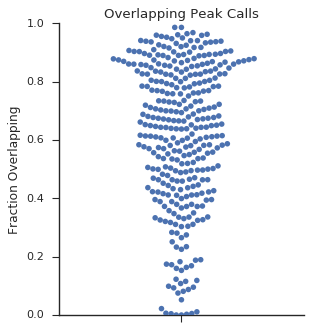

In [54]:
num_rows = 2 
num_cols = 1

with dataviz.Figure(os.path.join(img_dir, "gps_clipper_overlaps.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    sns.swarmplot(submitted_datasets_lengths.fraction_clipper_gsp_overlaps, orient='v', ax=ax)
    sns.despine(ax=ax)
    ax.set_title("Overlapping Peak Calls")
    ax.set_ylabel("Fraction Overlapping")
    ax.set_ylim(0,1)

Overlap is kind of whatever, ~60% on average, about as much as clipper replicates ironically enough

In [39]:
HTML(submitted_datasets_lengths.to_html())

# Does RBFOX2 have the known motif?

In [ ]:
GCATG_hg19_motif = pybedtools.BedTool("/projects/ps-yeolab3/oolite_backup/gpratt/projects/pipeline_analysis/motifs/hg19/motif_GCATG.BED")

def calc_percent_motif_in_peaks(peaks):
    peaks_with_motif = peaks.intersect(GCATG_hg19_motif, u=True)
    return len(peaks), len(peaks_with_motif), len(peaks_with_motif) / (len(peaks) * 1.0) 

In [ ]:
print "yuri", calc_percent_motif_in_peaks(yuri_peaks)
print "Unfiltered", calc_percent_motif_in_peaks(updated)
print "Lightly filtered", calc_percent_motif_in_peaks(filtered_loose_updated)
print "Strictly filtered", calc_percent_motif_in_peaks(filtered_updated)


# Does SLBP Bind Histones

In [ ]:
hist_genes = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/RNA_type_analysis/genelists.HISTall", header=None,
              )
genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_v19_genes.bed")

# Does FXR1 and FXR2 Bind only CDS

In [ ]:
#I can just do clip analyze for this one...
genes = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_v19_cds.bed")


# Do the Splicing Factors overlap the correct 3' or 5' splice site

In [ ]:
five_prime_ends = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_v19_five_prime_ends.bed")
three_prime_ends = pybedtools.BedTool("/home/gpratt/clipper/clipper/data/regions/hg19_v19_three_prime_ends.bed")


# Lets do cluster analysis!

In [21]:
def jaccard_by_peaks(fn_1, fn_2):
    out_dir = "/projects/ps-yeolab3/encode/analysis/gps_peaks"
    bedtool_1 = pybedtools.BedTool(fn_1)
    bedtool_2 = pybedtools.BedTool(fn_2)
    
    out_file_1 = os.path.basename(fn_1).split(".")[0]
    out_file_2 = os.path.basename(fn_2).split(".")[0]
     
    out_merge = os.path.join(out_dir, "{}_{}.merge".format(out_file_1, out_file_2))
    out_intersect = os.path.join(out_dir, "{}_{}.intersect".format(out_file_1, out_file_2))
    
    if not os.path.exists(out_merge):
        union_tool = bedtool_1.cat(bedtool_2).saveas(out_merge)
    else:
        union_tool = pybedtools.BedTool(out_merge)
    if not os.path.exists(out_intersect):
        intersection_tool = bedtool_1.intersect(bedtool_2, u=True, sorted=True).merge().saveas(out_intersect)
    else:
        intersection_tool = pybedtools.BedTool(out_intersect)
    return union_tool.fn, intersection_tool.fn
    #return len(intersection_tool) / (len(union_tool) * 1.0)

In [ ]:
result = defaultdict(dict)
for fn_1, fn_2 in itertools.product(processed_peaks.gps, processed_peaks.gps):
    result[os.path.basename(fn_1.split(".")[0])][os.path.basename(fn_2.split(".")[0])] = jaccard_by_peaks(fn_1, fn_2)

In [ ]:
result = pd.DataFrame(result)

In [ ]:
print "foo"

In [ ]:
sns.clustermap(result)

Look at comparison between old and new peaks (both filtered and unfiltered)
Look at actual peak locations, especially for RBPs that aren't behaving as expected like the U2AFs
Look at peaks outside of genes
See if Segway finished